[![Abrir en Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/juliopez/Taller-Fundamentos-Data-Science-Python/blob/main/03_Notebooks/05_Sesion_05.ipynb)

<img src=https://upload.wikimedia.org/wikipedia/commons/1/19/UDLA-logo-oficial.jpg width=400/>

# Fundamentos de Data Science con Python
**Dr. Julio Lopez-Nunez (2025)**

## **Sesión 5 – Clasificación de imágenes con MobileNetV2 (Transfer Learning)**  
**Duración total estimada:** 120 min  

## ⏱️ Objetivos (15 min)

### Objetivos de la actividad

- Aplicar el concepto de **Transfer Learning** usando MobileNetV2 preentrenado.
- Observar cómo un modelo preentrenado clasifica imágenes cotidianas.
- Identificar **aciertos**, **errores** y posibles **sesgos** del modelo.
- Conectar la experiencia práctica con los conceptos de **ética, sesgos e integridad en IA**.




## ⏱️ Introducción:

En esta práctica vamos a:

- Usar **MobileNetV2**, un modelo de visión por computadora ya entrenado en millones de imágenes (ImageNet).
- Clasificar imágenes reales podrán subir desde su computador.
- Analizar **aciertos y errores** del modelo.
- Reflexionar sobre posibles **sesgos** y limitaciones del modelo, conectando con lo visto en la teoría.

> Recordatorio: *un modelo puede ser muy preciso en promedio, pero profundamente injusto en casos específicos.*

---

### 1. ¿Por qué las CNN son mejores que un MLP para imágenes?

- Un MLP **no reconoce patrones espaciales** (solo recibe un vector plano).
- Una CNN sí puede analizar una imagen en pequeñas regiones.
- Detecta patrones locales como **bordes, líneas, texturas y formas**.
- Las primeras capas ven patrones simples; las profundas, patrones complejos.

---

### 2. Convolución (filtros)

- Un *filtro* (3×3 o 5×5) se desplaza sobre la imagen.
- Cada filtro aprende a detectar un tipo de patrón.
- Produce un **mapa de características** (*feature map*).

La convolución es el “ojo” de la red.

---

### 3. Pooling

- Toma un bloque pequeño (por ejemplo, 2×2) y selecciona un valor (max/avg).
- Reduce el tamaño de los mapas.
- Aumenta eficiencia y robustez al ruido.

El pooling es un “resumen” de las características detectadas.

---

### 4. Transfer Learning

- En vez de entrenar desde cero, usamos un modelo ya entrenado
  en millones de imágenes (ImageNet).
- Reutilizamos sus primeras capas (que ya saben detectar características generales).
- Solo entrenamos o usamos la capa final.

*No comenzamos de cero: aprovechamos conocimiento previo.*

---

### 5. Ética, sesgos e integridad

- Los modelos pueden contener **sesgos** por los datos con los que fueron entrenados.
- Un modelo puede ser preciso en promedio pero fallar en casos específicos.
- Por eso debemos observar:
  - Aciertos  
  - Errores  
  - Posibles sesgos  
  - Limitaciones  
- Y actuar siempre con criterio académico y ético.

---

### ¿Qué haremos ahora?

Usaremos **MobileNetV2** (modelo preentrenado) para clasificar imágenes reales
y analizaremos:

- qué tan bien funciona,  
- dónde se equivoca,  
- y qué tipo de sesgos o fallas podrían estar presentes.

> *“Por eso, en la práctica con MobileNetV2 analizaremos no solo aciertos, sino también posibles errores y sesgos.”*


## ⏱️ Actividad práctica (50–60 min)

In [7]:
# PASO 1: Importar librerías
# --------------------------
# Esta sesión trabaja con modelos convolucionales preentrenados (CNN)
# y técnicas de Transfer Learning. Por eso necesitamos librerías
# especializadas para cargar modelos, procesar imágenes y mostrar resultados.

# Librerías básicas
import numpy as np
import matplotlib.pyplot as plt
# numpy: usado para manipular arreglos numéricos
# matplotlib: usado para visualizar imágenes y resultados

# Importar MobileNetV2 y funciones asociadas desde Keras
from tensorflow.keras.applications.mobilenet_v2 import (
    MobileNetV2,         # Modelo CNN preentrenado en ImageNet
    preprocess_input,    # Función de preprocesamiento específica de MobileNetV2
    decode_predictions,  # Convierte las probabilidades en etiquetas legibles
)

# Herramientas para cargar y convertir imágenes
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# load_img: abre una imagen desde el disco
# img_to_array: convierte una imagen en un arreglo numérico listo para la red

# Librerías del entorno Google Colab
from google.colab import files              # Permite subir imágenes desde el computador del usuario
from IPython.display import display, Image, Markdown
# display/Image: permiten mostrar imágenes directamente en el notebook
# Markdown: permite mostrar texto enriquecido en formato Markdown


In [8]:
# PASO 2: Cargar MobileNetV2 preentrenado en ImageNet
# ----------------------------------------------------
# MobileNetV2 es una red neuronal convolucional moderna y liviana,
# entrenada previamente con el dataset ImageNet (1.4 millones de imágenes, 1000 clases).
#
# Gracias al preentrenamiento, el modelo ya aprendió:
#   - bordes, texturas, formas básicas (capas iniciales)
#   - patrones más complejos (capas profundas)
#   - conceptos visuales de objetos reales (salida con 1000 categorías)
#
# include_top=True:
#   - Mantiene la capa final de clasificación de ImageNet.
#   - Esto permite usar el modelo "tal cual viene" para clasificar imágenes en las 1000 clases originales.
#   - Si quisiéramos usar Transfer Learning para otro problema (ej: clasificar imágenes propias),
#     usaríamos include_top=False y construiríamos una capa final nueva.

modelo = MobileNetV2(weights="imagenet", include_top=True)

print("Modelo MobileNetV2 cargado correctamente.")


Modelo MobileNetV2 cargado correctamente.


In [14]:
# PASO 3: Función de preprocesamiento de imágenes
# ------------------------------------------------
# MobileNetV2 solo puede recibir imágenes en un formato específico:
#   - tamaño 224x224 píxeles
#   - 3 canales (RGB)
#   - valores preprocesados según la función preprocess_input
#
# Esta función toma la ruta de una imagen, la procesa paso a paso
# y la deja lista para ser enviada al modelo.

def preparar_imagen(ruta_imagen, tamaño=(224, 224)):
    """
    Carga una imagen desde disco, la redimensiona y la prepara
    para ser usada por MobileNetV2.
    """

    # 1. Cargar la imagen desde la ruta y redimensionarla al tamaño requerido por MobileNetV2
    img = load_img(ruta_imagen, target_size=tamaño)

    # 2. Convertir la imagen a un arreglo numpy (tensor)
    img_array = img_to_array(img)  # shape original: (224, 224, 3)

    # 3. Expandir dimensiones para simular un batch de 1 imagen
    # MobileNetV2 espera una entrada con forma (batch, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)  # ahora: (1, 224, 224, 3)

    # 4. Aplicar preprocesamiento específico de MobileNetV2
    # Esto normaliza los valores de la imagen en el rango adecuado.
    img_array = preprocess_input(img_array)

    return img, img_array


In [15]:
# PASO 4: Subir imágenes desde el computador
# ------------------------------------------
# Google Colab permite cargar archivos manualmente usando files.upload().

print("Sube una o más imágenes (jpg, jpeg, png)...")

# Abre un cuadro de diálogo para seleccionar imágenes desde el computador local.
# 'archivos_subidos' será un diccionario donde:
#   - la clave: nombre del archivo
#   - el valor: el contenido binario de la imagen
archivos_subidos = files.upload()

# Extraemos los nombres de los archivos subidos para procesarlos después.
nombres_imagenes = list(archivos_subidos.keys())

print("\nImágenes cargadas:")
for nombre in nombres_imagenes:
    print(" -", nombre)


Sube una o más imágenes (jpg, jpeg, png)...


Saving Gato3.jpg to Gato3 (1).jpg
Saving MoteConHuesillo.jpeg to MoteConHuesillo (1).jpeg
Saving perro1.webp to perro1 (1).webp

Imágenes cargadas:
 - Gato3 (1).jpg
 - MoteConHuesillo (1).jpeg
 - perro1 (1).webp


Imagen: Gato3 (1).jpg


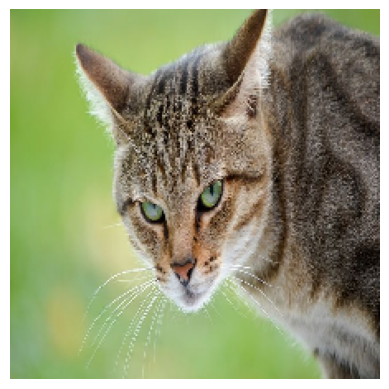

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Top-3 predicciones:
    1. tiger_cat (83.97%)
    2. tabby (6.45%)
    3. Egyptian_cat (3.24%)
Imagen: MoteConHuesillo (1).jpeg


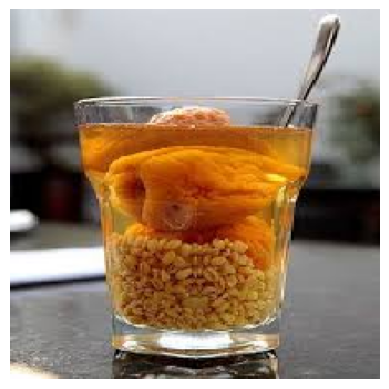

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Top-3 predicciones:
    1. beer_glass (15.43%)
    2. espresso (12.33%)
    3. beaker (10.23%)
Imagen: perro1 (1).webp


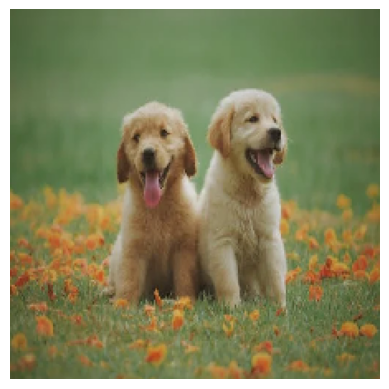

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Top-3 predicciones:
    1. standard_poodle (37.97%)
    2. golden_retriever (26.35%)
    3. Labrador_retriever (6.13%)


In [16]:
# PASO 5: Clasificar imágenes y mostrar predicciones
# --------------------------------------------------
# En este paso tomamos cada imagen cargada por el usuario, la preprocesamos,
# la enviamos al modelo MobileNetV2, y mostramos las 3 clases más probables.
#
# Además guardamos los resultados para un análisis posterior (p. ej., detección de sesgos).

resultados = []  # Lista donde guardaremos los resultados de cada imagen

for nombre in nombres_imagenes:
    print("=" * 80)
    print(f"Imagen: {nombre}")

    # 1. Guardar archivo en disco temporal
    # Google Colab maneja archivos subidos en memoria; aquí los escribimos
    # para poder usarlos con load_img().
    with open(nombre, "wb") as f:
        f.write(archivos_subidos[nombre])

    # 2. Preparar imagen: redimensionar + convertir a tensor + preprocesar
    img_original, img_preparada = preparar_imagen(nombre)

    # 3. Mostrar la imagen original
    plt.imshow(img_original)
    plt.axis("off")
    plt.show()

    # 4. Realizar predicción con MobileNetV2
    # Esto devuelve probabilidades para 1000 clases diferentes.
    preds = modelo.predict(img_preparada)

    # 5. Decodificar predicciones a etiquetas comprensibles
    # decode_predictions devuelve el top-k con nombres humanos (ej.: "Egyptian_cat").
    top3 = decode_predictions(preds, top=3)[0]

    print("Top-3 predicciones:")
    predicciones_legibles = []
    for i, (id_clase, etiqueta, prob) in enumerate(top3, start=1):
        texto = f"{i}. {etiqueta} ({prob:.2%})"
        print("   ", texto)
        predicciones_legibles.append(texto)

    # 6. Guardar resultados organizados para análisis posterior
    resultados.append({
        "nombre_archivo": nombre,
        "predicciones": predicciones_legibles,
    })


In [17]:
# PASO 6: Resumen rápido de resultados
# ------------------------------------
# En este paso mostramos un resumen consolidado de todas las imágenes clasificadas.
# Es una manera rápida de revisar:
#   - cuáles imágenes se procesaron
#   - cuáles fueron las predicciones top-3 para cada una
#   - y comparar los resultados sin necesidad de revisar cada salida por separado

print("RESUMEN DE PREDICCIONES")
print("-" * 80)

for r in resultados:
    print(f"Imagen: {r['nombre_archivo']}")

    # Mostrar las predicciones legibles guardadas previamente
    for linea in r["predicciones"]:
        print("   ", linea)

    print("-" * 80)


RESUMEN DE PREDICCIONES
--------------------------------------------------------------------------------
Imagen: Gato3 (1).jpg
    1. tiger_cat (83.97%)
    2. tabby (6.45%)
    3. Egyptian_cat (3.24%)
--------------------------------------------------------------------------------
Imagen: MoteConHuesillo (1).jpeg
    1. beer_glass (15.43%)
    2. espresso (12.33%)
    3. beaker (10.23%)
--------------------------------------------------------------------------------
Imagen: perro1 (1).webp
    1. standard_poodle (37.97%)
    2. golden_retriever (26.35%)
    3. Labrador_retriever (6.13%)
--------------------------------------------------------------------------------


## Análisis crítico: aciertos, errores y posibles sesgos

1. **Selecciona 1 o 2 imágenes donde el modelo haya fallado**  
   - ¿Qué mostró la imagen realmente?  
   - ¿Qué predijo MobileNetV2?  

2. **Piensa por qué pudo cometer ese error:**
   - ¿La imagen tenía ángulos extraños, poca luz, mucha textura, ruido?  
   - ¿El objeto es poco común o muy específico de tu contexto?  
   - ¿Puede haber diferencias culturales (por ejemplo, tipos de alimentos, objetos locales)?  

3. **Conecta con los tipos de sesgos vistos en la PPT:**
   - ¿Dataset Bias? ¿Measurement Bias? ¿Sampling Bias? ¿Algorithmic Bias?  
   - ¿Qué tipo de sesgo podría estar influyendo en el error?

4. **Reflexiona sobre el uso responsable de estos modelos:**
   - ¿Confiarías en este modelo para una decisión importante?  
   - ¿Qué supervisión humana sería necesaria?  

> **Recuerda:** *Un modelo puede ser muy preciso en promedio, pero profundamente injusto en casos específicos.*  
> Por eso, en esta práctica buscamos analizar **no solo aciertos, sino también posibles errores y sesgos**.


## ⏱️ Reflexión Final

Escribe aquí una reflexión breve (6–10 líneas) sobre:

- Un ejemplo de acierto o error interesante del modelo.
- Qué tipo de sesgo podría estar presente (si aplica).
- Qué implicancias tendría usar este tipo de modelos en educación, salud u otros contextos.
- Qué buenas prácticas crees que son necesarias para usar IA de forma ética y responsable.

# Y SI LO HACEMOS DESDE CERO.....

In [52]:
# PASO 1: Importar librerías para una CNN sencilla

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory

print("Versión de TensorFlow:", tf.__version__)



Versión de TensorFlow: 2.19.0


In [53]:
# PASO 2: Cargar imágenes desde directorios
# -----------------------------------------
# Asumimos una estructura como:
# datos_cnn/
#    clase1/
#       img1.jpg, img2.jpg, ...
#    clase2/
#       imgA.jpg, imgB.jpg, ...

ruta_datos = "datos_cnn"  # Ajustar según donde se haya creado la carpeta

tamaño_imagen = (128, 128)   # Más pequeño que 224x224 para ir rápido
batch_size = 4               # Muy pequeño porque tenemos pocas imágenes

# Cargar dataset y dividir en train/validation
dataset_entrenamiento = image_dataset_from_directory(
    ruta_datos,
    validation_split=0.3,        # 70% train, 30% validation
    subset="training",
    seed=42,
    image_size=tamaño_imagen,
    batch_size=batch_size,
)

dataset_validacion = image_dataset_from_directory(
    ruta_datos,
    validation_split=0.3,
    subset="validation",
    seed=42,
    image_size=tamaño_imagen,
    batch_size=batch_size,
)

# Ver nombres de clases detectadas (según nombres de carpetas)
clases = dataset_entrenamiento.class_names
print("Clases detectadas:", clases)


Found 19 files belonging to 2 classes.
Using 14 files for training.
Found 19 files belonging to 2 classes.
Using 5 files for validation.
Clases detectadas: ['Gato', 'Perro']


In [60]:
# PASO 3: Definir un modelo CNN sencillo desde cero
# -------------------------------------------------
# Arquitectura mínima:
#   - 2 bloques Conv2D + MaxPooling
#   - Flatten
#   - 1 capa densa intermedia
#   - Capa de salida con softmax

num_clases = len(clases)

# Definimos una CNN sencilla utilizando un modelo Sequential.
# La arquitectura es pequeña porque trabajamos con muy pocas imágenes,
# pero contiene los elementos esenciales de una red convolucional moderna.

modelo_cnn = models.Sequential([

    # 1) Normalización inicial
    # ------------------------
    # Convierte los valores de los píxeles desde [0, 255] a [0, 1].
    # Esto ayuda a que el entrenamiento sea más estable y rápido.
    layers.Rescaling(1./255, input_shape=(*tamaño_imagen, 3)),

    # 2) Primer bloque convolucional
    # ------------------------------
    # Conv2D: aplica 16 filtros de tamaño 3x3.
    # Cada filtro aprende un patrón visual simple (bordes, texturas).
    layers.Conv2D(16, (3, 3), activation="relu"),

    # MaxPooling2D: reduce la dimensión espacial (hace downsampling).
    # Esto ayuda a extraer los patrones más importantes y reduce el ruido.
    layers.MaxPooling2D((2, 2)),

    # 3) Segundo bloque convolucional
    # -------------------------------
    # Más filtros (32) → el modelo aprende patrones más complejos.
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    # 4) Aplanamiento de los mapas de características
    # -----------------------------------------------
    # Convierte las matrices 2D de características en un vector 1D
    # para poder conectarse con las capas densas.
    layers.Flatten(),

    # 5) Capa densa (fully connected)
    # -------------------------------
    # Combina las características extraídas por la CNN.
    # Con 64 neuronas, la red aprende combinaciones más abstractas.
    layers.Dense(64, activation="relu"),

    # 6) Capa de salida
    # -----------------
    # Tiene tantas neuronas como clases queremos predecir.
    # Softmax produce una probabilidad para cada clase.
    layers.Dense(num_clases, activation="softmax")
])


modelo_cnn.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │     1,843,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,848,482 (7.05 MB)

 Trainable params: 1,848,482 (7.05 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# PASO 4: Compilar y entrenar el modelo
# -------------------------------------
# Como es un problema de clasificación multiclase:
#   - Pérdida: sparse_categorical_crossentropy (etiquetas enteras)
#   - Métrica: accuracy
#   - Optimizador: Adam

modelo_cnn.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Entrenamos con pocas epochs, porque tenemos muy pocas imágenes
epochs = 10

historial = modelo_cnn.fit(
    dataset_entrenamiento,
    validation_data=dataset_validacion,
    epochs=epochs
)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.3381 - loss: 4.5414 - val_accuracy: 0.4000 - val_loss: 6.2134
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5452 - loss: 4.8716 - val_accuracy: 0.4000 - val_loss: 1.5936
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4060 - loss: 1.0599 - val_accuracy: 0.6000 - val_loss: 0.8683
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3881 - loss: 0.8850 - val_accuracy: 0.6000 - val_loss: 0.7436
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.7774 - loss: 0.6392 - val_accuracy: 0.0000e+00 - val_loss: 0.7388
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7690 - loss: 0.5905 - val_accuracy: 0.4000 - val_loss: 0.8141
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5869 - loss: 0.5586 - val_accuracy: 0.4000 - val_loss: 0.8519
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5286 - loss: 0.5130 - val_accuracy: 0.2000 - val_loss: 0.

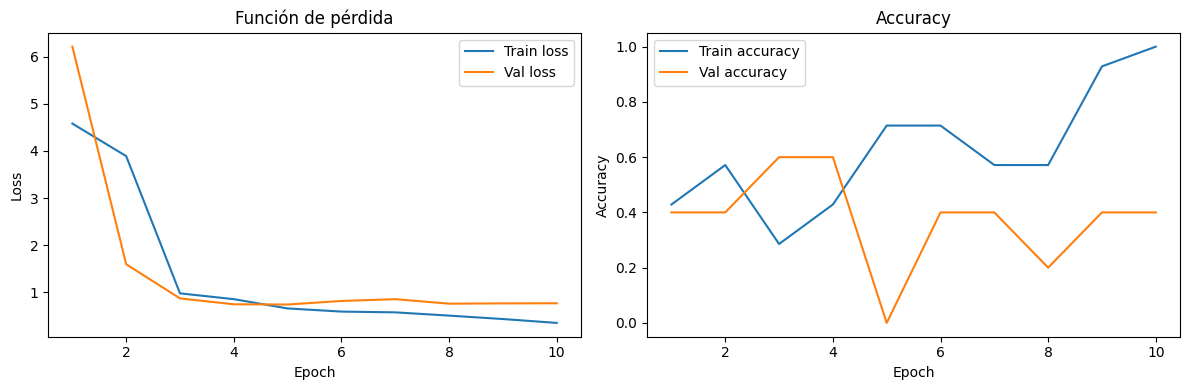

In [56]:
# PASO 5: Visualizar el entrenamiento (loss y accuracy)
# -----------------------------------------------------

hist = historial.history
epocas = range(1, len(hist["loss"]) + 1)

plt.figure(figsize=(12, 4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(epocas, hist["loss"], label="Train loss")
plt.plot(epocas, hist["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Función de pérdida")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epocas, hist["accuracy"], label="Train accuracy")
plt.plot(epocas, hist["val_accuracy"], label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


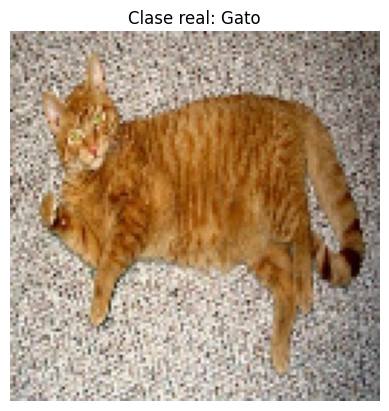

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Predicción de la CNN: Perro


In [57]:
# PASO 6: Probar el modelo con una imagen individual
# --------------------------------------------------
# Tomamos un batch del dataset de validación y probamos con una imagen.

for imagenes, etiquetas_reales in dataset_validacion.take(1):
    img = imagenes[0]
    etiqueta_real = etiquetas_reales[0].numpy()

    plt.imshow(img.numpy().astype("uint8"))
    plt.axis("off")
    plt.title(f"Clase real: {clases[etiqueta_real]}")
    plt.show()

    # Expandimos dimensiones para simular batch de tamaño 1
    img_batch = tf.expand_dims(img, axis=0)

    # Predicción
    pred_probs = modelo_cnn.predict(img_batch)
    pred_label = np.argmax(pred_probs, axis=1)[0]

    print("Predicción de la CNN:", clases[pred_label])


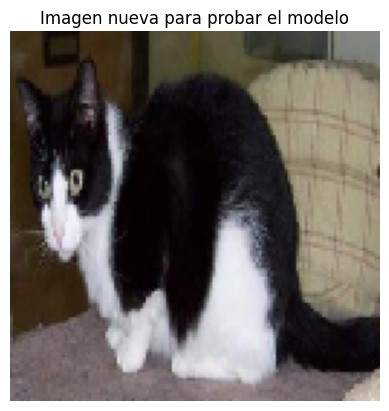

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Probabilidades por clase: [[0.74697536 0.2530246 ]]
Predicción final: Gato


In [59]:
# PROBAR LA CNN CON UNA IMAGEN NUEVA
# ----------------------------------

from tensorflow.keras.preprocessing import image

# 1. Selecciona la ruta de una imagen nueva (fuera del dataset de entrenamiento)
ruta_imagen_nueva = "/content/cat.958.jpg"  # Cambia por el nombre de tu archivo

# 2. Cargar y preprocesar imagen
img = image.load_img(ruta_imagen_nueva, target_size=tamaño_imagen)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # -> (1, 128,128,3)

# 3. Mostrar imagen
plt.imshow(img)
plt.axis("off")
plt.title("Imagen nueva para probar el modelo")
plt.show()

# 4. Realizar predicción
pred_probs = modelo_cnn.predict(img_array)
pred_label = np.argmax(pred_probs, axis=1)[0]

# 5. Mostrar resultado
print("Probabilidades por clase:", pred_probs)
print("Predicción final:", clases[pred_label])



# Glosario de Términos — Sesión 5: CNN y Transfer Learning

| Término | Significado en palabras sencillas |
|--------|------------------------------------|
| **CNN (Convolutional Neural Network)** | Tipo de red neuronal especializada en imágenes; aprende patrones como bordes, texturas y formas. |
| **Convolución** | Operación donde un filtro recorre la imagen buscando patrones. Produce mapas de características. |
| **Filtro / Kernel** | Pequeño detector de patrones. Cada filtro aprende a detectar algo distinto (bordes, curvas, texturas). |
| **Conv2D(16, 3×3)** | Capa con 16 filtros de tamaño 3×3. Significa 16 detectores aprendiendo patrones visuales. |
| **MaxPooling** | Reduce el tamaño de la imagen destacando las características más importantes. Ayuda a evitar ruido. |
| **Mapa de características (Feature Map)** | Resultado de aplicar un filtro. Es la “imagen filtrada” que resalta un patrón aprendido. |
| **Flatten** | Convierte los mapas de características (matrices) en un vector para conectarlos con capas densas. |
| **Capa Densa (Dense)** | Capa tradicional de neuronas totalmente conectadas. Toma decisiones finales combinando las características extraídas. |
| **Softmax** | Función que convierte los valores finales en probabilidades por clase. |
| **Normalización / Rescaling** | Ajusta los valores de los píxeles para que el modelo aprenda mejor (por ejemplo, pasar de [0–255] a [0–1]). |
| **Preprocesamiento (`preprocess_input`)** | Transformación específica requerida por modelos preentrenados para darles imágenes en el formato correcto. |
| **MobileNetV2** | CNN preentrenada, ligera y eficiente, entrenada con 1.4M de imágenes de ImageNet. Ideal para clasificación. |
| **Imagen preentrenada (ImageNet)** | Gran dataset con 1000 clases. MobileNetV2 ya sabe reconocer muchos objetos comunes. |
| **Transfer Learning** | Reutilizar un modelo preentrenado para un nuevo problema, en vez de entrenar desde cero. |
| **include_top=True** | Mantiene la capa final original del modelo preentrenado (las 1000 clases de ImageNet). |
| **include_top=False** | Quita la capa final del modelo para agregar una nueva salida personalizada (ej: 3 clases propias). |
| **Fine-Tuning** | Ajustar algunas capas del modelo preentrenado para que aprenda mejor un nuevo dataset. |
| **Overfitting** | Cuando el modelo memoriza demasiado el dataset y no generaliza a imágenes nuevas. |
| **Dataset pequeño** | Pocas imágenes → alta probabilidad de overfitting. CNN pequeñas funcionan mejor en este caso. |
| **Batch Size** | Cantidad de imágenes procesadas juntas en cada paso de entrenamiento. |
| **Epoch** | Una pasada completa por todo el dataset durante el entrenamiento. |
| **Predicción Top-3** | Las tres clases más probables que el modelo cree ver en la imagen. |
| **Algorithmic Bias** | Cuando el modelo produce resultados sistemáticamente inclinados o erróneos debido a datos sesgados o pobre generalización. |
